In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import minimize

In [19]:
def gaussian(eval_point, tab_point, radius=5, tab_scale=3):
    ex, ey = eval_point ; tx, ty = tab_point
    numerator = -((ex-tx)**2+(ey-ty)**2)
    denominator = tab_scale**2*radius**2
    return np.exp(numerator / denominator)

def iterate_points(eval_point, tab_points):
    vals = list(map(gaussian, [eval_point]*len(tab_points), tab_points))
    return max(vals)

def riemann_sum(room, tab_points: list):
    roomw, roomh = room.shape
    meshx = np.arange(0, roomw) ; meshy = np.arange(0, roomh)
    meshx, meshy = np.meshgrid(meshx, meshy)
    max_influence = np.zeros_like(meshx)
    # tab_points.append((0, 25))
    for tabx, taby in tab_points:
        val = gaussian((meshx, meshy), (tabx, taby))
        max_influence = np.maximum(max_influence, val)
    return max_influence, np.sum(max_influence)

In [20]:
def visualize(max_influence: np.array, tab_points, tab_rad=5):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(max_influence.T, origin='lower', cmap='viridis', aspect='equal')
    for tab_point in tab_points:
        tab_point = tab_point[::-1]
        circ = plt.Circle(tab_point, tab_rad, fill=False)
        ax.add_patch(circ)
    ax.set_xlabel('x (ft)')
    ax.set_ylabel('y (ft)')
    ax.set_title('Height Field (Top View)')
    
    plt.colorbar(im, ax=ax, label='h(x,y)')
    plt.show()

In [ ]:
def visualize_3d(max_influence: np.array, integral, elev=30, azim=45):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Get the shape
    W, H = max_influence.shape
    
    # Create coordinate arrays
    x = np.arange(W)
    y = np.arange(H)
    meshx, meshy = np.meshgrid(x, y)
    
    surf = ax.plot_surface(meshx, meshy, max_influence.T, 
                          cmap='viridis', edgecolor='none', alpha=0.9)
    
    # Set viewing angle
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f'Integral: {integral}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('h(x,y)')
    plt.colorbar(surf, ax=ax, shrink=0.5)
    plt.show()

NameError: name 'max_influence' is not defined

[[1.         0.99556542 0.98237931 0.96078944 0.9313584  0.89483932
  0.85214379 0.80430416 0.75243216 0.69767633 0.64118039 0.58404469
  0.52729242 0.47184199 0.41848631 0.36787944 0.32053052 0.27680432
  0.23692776 0.20100119 0.16901332 0.14085842 0.1163548  0.09526326
  0.07730474]
 [0.99556542 0.9911505  0.97802287 0.95652874 0.92722822 0.89087108
  0.84836489 0.8007374  0.74909543 0.69458242 0.63833702 0.58145469
  0.5249541  0.46974957 0.41663049 0.36624805 0.3191091  0.27557681
  0.23587708 0.20010983 0.16826381 0.14023377 0.11583882 0.0948408
  0.07696193]
 [0.98237931 0.97802287 0.96506912 0.94385967 0.91494723 0.87907163
  0.83712843 0.79013177 0.73917379 0.68538279 0.62988235 0.57375342
  0.51800117 0.46352781 0.41111229 0.36139715 0.31488255 0.27192684
  0.23275293 0.19745941 0.16603518 0.1383764  0.11430455 0.09358465
  0.07594258]
 [0.96078944 0.95652874 0.94385967 0.92311635 0.89483932 0.85975217
  0.81873075 0.77276694 0.72292887 0.67032005 0.61603935 0.56114397
  0.506

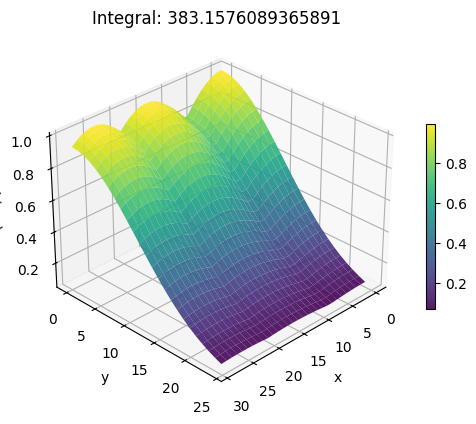

In [23]:
room = np.zeros((25, 30))
tab_points = [(0, 0), (0, 25), (0, 15)]
# tab_points = [(5, 5), (12, 25), (18, 15)]
room, integral = riemann_sum(room, tab_points)
print(room)
print(f'Integral: {integral}')
visualize_3d(room, integral)

In [ ]:
def objective_function(p, room_size, radius, tab_scale):
    n_tables = len(p) // 2
    tab_points = [(p[2*i], p[2*i+1]) for i in range(n_tables)]
    room = np.zeros(room_size)
    max_influence, integral = riemann_sum(room, tab_points)
    return -integral


def constraint_no_overlap(p, radius):
    n_tables = len(p) // 2
    min_dist = float('inf')
    for i in range(n_tables):
        for j in range(i+1, n_tables):
            x1, y1 = p[2*i], p[2*i+1]
            x2, y2 = p[2*j], p[2*j+1]
            dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            min_dist = min(min_dist, dist)
    return min_dist - 2*radius


def optimize_tables(room_size, n_tables=4, radius=2.5, tab_scale=3):
    W, H = room_size
    initial = []
    for i in range(n_tables):
        x = (i % 2 + 1) * W / 3
        y = (i // 2 + 1) * H / 3
        initial.extend([x, y])
    
    initial = np.array(initial)
    bounds = []
    for i in range(n_tables):
        bounds.append((radius, W - radius))
        bounds.append((radius, H - radius))
    
    constraints = {
        'type': 'ineq',
        'fun': constraint_no_overlap,
        'args': (radius,)
    }
    

    result = minimize(
        objective_function,
        initial,
        args=(room_size, radius, tab_scale),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 100, 'disp': True, 'ftol': 1e-6}
    )
    
    optimal_positions = [(result.x[2*i], result.x[2*i+1]) for i in range(n_tables)]
    optimal_integral = -result.fun
    
    return optimal_positions, optimal_integral, result

Starting optimization...
Initial positions: [(np.float64(6.666666666666667), np.float64(8.333333333333334)), (np.float64(13.333333333333334), np.float64(8.333333333333334)), (np.float64(6.666666666666667), np.float64(16.666666666666668)), (np.float64(13.333333333333334), np.float64(16.666666666666668))]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -458.2957038814582
            Iterations: 17
            Function evaluations: 157
            Gradient evaluations: 17

OPTIMIZATION COMPLETE
Success: True
Message: Optimization terminated successfully
Iterations: 17

Optimal positions:
  Table 1: (4.71, 4.39)
  Table 2: (14.74, 6.01)
  Table 3: (4.96, 14.84)
  Table 4: (14.18, 18.92)

Optimal integral: 458.2957


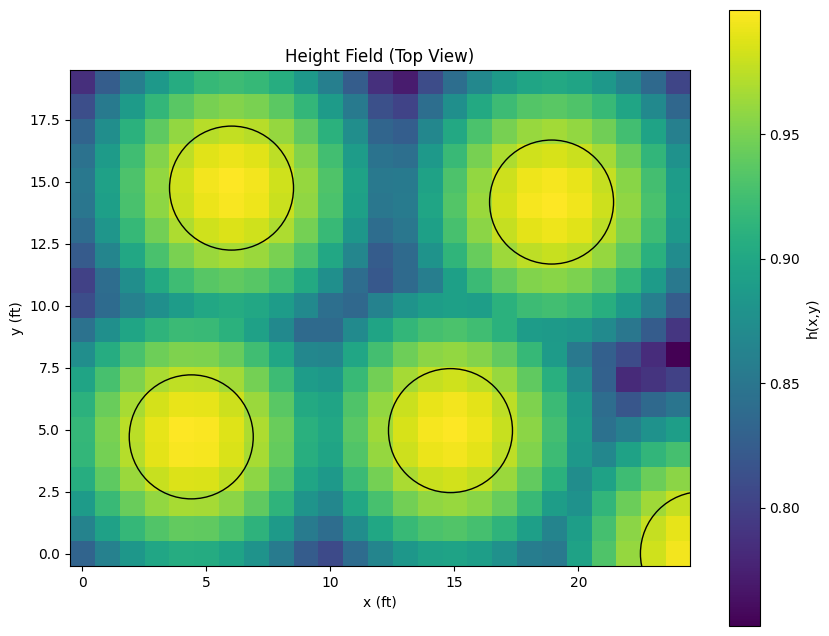


Comparing with initial configuration:
Initial integral: 435.8509
Optimized integral: 458.2957
Improvement: 5.1%


In [ ]:
room_size = (20, 25)
optimal_positions, max_integral, result = optimize_tables(
    room_size, 
    n_tables=4, 
    radius=2.5, 
    tab_scale=3
)

room = np.zeros(room_size)
max_influence, integral = riemann_sum(room, optimal_positions)
visualize(max_influence, optimal_positions, tab_rad=2.5)
initial_config = [(7, 7), (18, 7), (7, 13), (18, 13)]
room_init = np.zeros(room_size)
_, initial_integral = riemann_sum(room_init, initial_config)